In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('/content/drive/MyDrive/deepfake-detection-master')

In [3]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [9]:
train_frame_folder = 'train_sample_videos'
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('/content/drive/MyDrive/deepfake-detection-master/dataset/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('/content/drive/MyDrive/deepfake-detection-master/dataset/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                count+=1

In [4]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [6]:
input_shape = (128, 128, 3)
data_dir = '/content/drive/MyDrive/deepfake-detection-master/dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [7]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import legacy

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=legacy.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

219055592/219055592 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
#Currently not used
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
30/30 [==============================] - 59s 895ms/step - loss: 0.6324 - accuracy: 0.7109 - val_loss: 0.6156 - val_accuracy: 0.7316
Epoch 2/20
30/30 [==============================] - 16s 530ms/step - loss: 0.5358 - accuracy: 0.8274 - val_loss: 0.6078 - val_accuracy: 0.7250
Epoch 3/20
30/30 [==============================] - 16s 539ms/step - loss: 0.4557 - accuracy: 0.8728 - val_loss: 0.5975 - val_accuracy: 0.7303
Epoch 4/20
30/30 [==============================] - 16s 547ms/step - loss: 0.3854 - accuracy: 0.9035 - val_loss: 0.5874 - val_accuracy: 0.7236
Epoch 5/20
30/30 [==============================] - 17s 552ms/step - loss: 0.3148 - accuracy: 0.9403 - val_loss: 0.5673 - val_accuracy: 0.7517
Epoch 6/20
30/30 [==============================] - 16s 551ms/step - loss: 0.2559 - accuracy: 0.9523 - val_loss: 0.5375 - val_accuracy: 0.7864
Epoch 7/20
30/30 [==============================] - 17s 555ms/step - loss: 0.2033 - accuracy: 0.9609 - val_loss: 0.4949 - val_accuracy: 0.7971

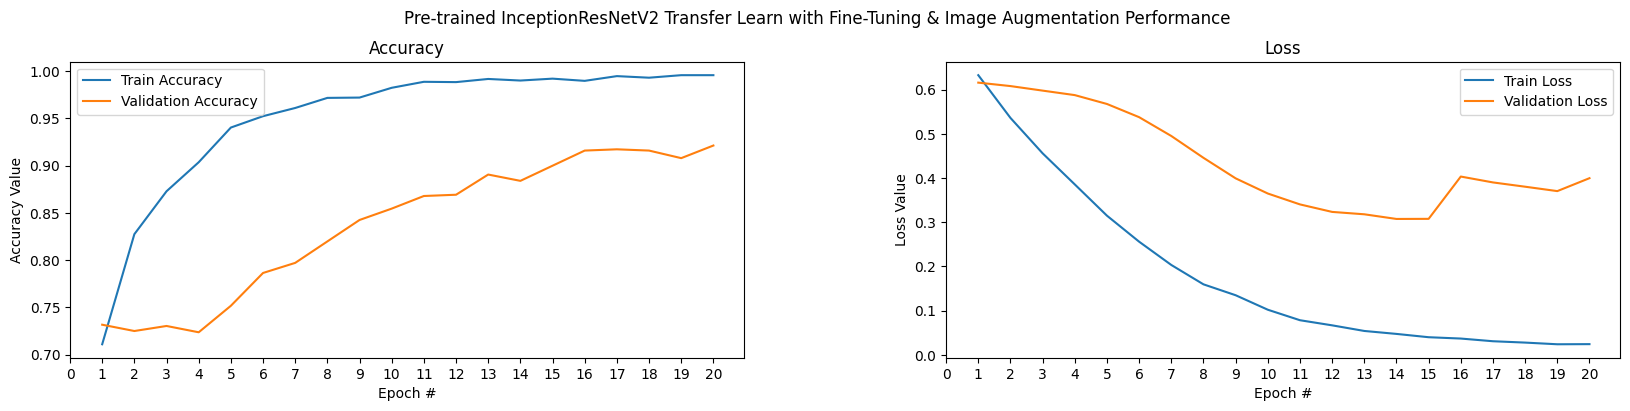

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

118/118 [==============================] - 12s 60ms/step
True positive =  2940
False positive =  46
False negative =  35
True negative =  724




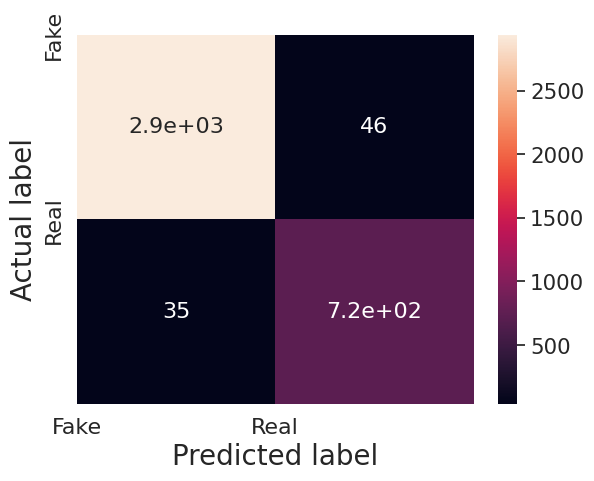

In [13]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
    cm = confusion_matrix(y_true, y_pred_classes)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()

print_confusion_matrix(Y_val_org, model.predict(X))  # Use predict method instead of predict_classes

In [19]:
model.save('/content/drive/MyDrive/deepfake-detection-master/model/deepfake-detection-model.h5')

In [17]:
import tensorflow as tf
import dlib
import cv2
import os
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [18]:
tf.__version__

'2.12.0'

In [20]:
model = load_model('/content/drive/MyDrive/deepfake-detection-master/model/deepfake-detection-model.h5')

In [49]:
import numpy as np
input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('/content/mf.mp4')
frameRate = cap.get(5)
while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if ret != True:
        break
    if frameId % ((int(frameRate)+1)*1) == 0:
        face_rects, scores, idx = detector.run(frame, 0)
        for i, d in enumerate(face_rects):
            x1 = d.left()
            y1 = d.top()
            x2 = d.right()
            y2 = d.bottom()
            crop_img = frame[y1:y2, x1:x2]
            data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
            data = data.reshape(-1, 128, 128, 3)
            print(np.argmax(model.predict(data), axis=-1))

1/1 [==============================] - 0s 37ms/step
[0]
1/1 [==============================] - 0s 39ms/step
[1]
1/1 [==============================] - 0s 38ms/step
[0]
1/1 [==============================] - 0s 35ms/step
[0]
1/1 [==============================] - 0s 42ms/step
[0]
1/1 [==============================] - 0s 38ms/step
[0]
1/1 [==============================] - 0s 36ms/step
[0]
1/1 [==============================] - 0s 34ms/step
[0]
1/1 [==============================] - 0s 39ms/step
[0]
1/1 [==============================] - 0s 43ms/step
[0]
1/1 [==============================] - 0s 37ms/step
[0]
1/1 [==============================] - 0s 38ms/step
[1]
1/1 [==============================] - 0s 38ms/step
[0]
1/1 [==============================] - 0s 38ms/step
[0]
1/1 [==============================] - 0s 38ms/step
[0]
1/1 [==============================] - 0s 38ms/step
[0]
1/1 [==============================] - 0s 36ms/step
[0]
1/1 [==============================] - 0s 36ms/s

1/1 [==============================] - 0s 39ms/step


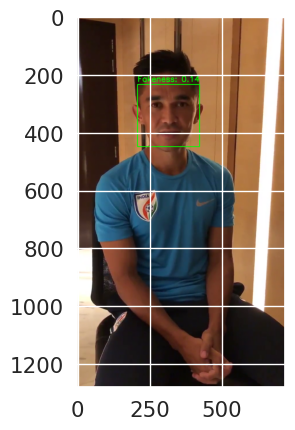

1/1 [==============================] - 0s 43ms/step


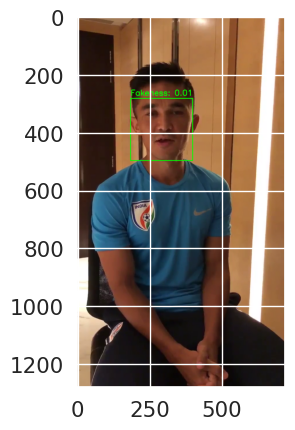

1/1 [==============================] - 0s 39ms/step


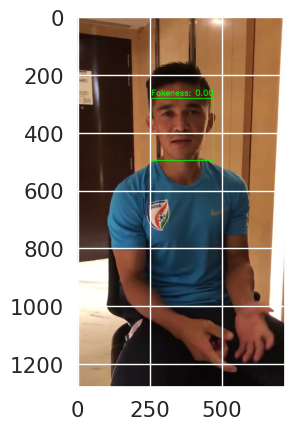

1/1 [==============================] - 0s 38ms/step


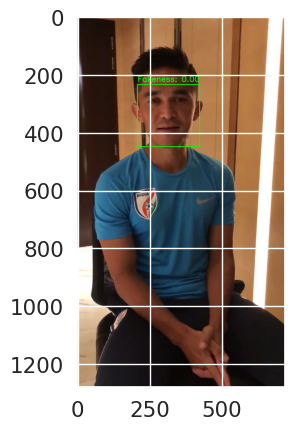

1/1 [==============================] - 0s 56ms/step


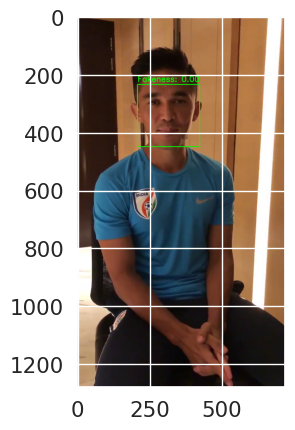

The percentage of fakeness is: 2.945440635085106
The maximum probability of fakeness is: 0.13899852
The minimum probability of fakeness is: 0.00012755652


In [67]:
import numpy as np
import random
import matplotlib.pyplot as plt

input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('/content/sample_data/CCqaaV-vtmtmDifI.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameNumbers = random.sample(range(frameCount), 5) # Select 5 random frame numbers
scores = []

for frameId in frameNumbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frameId)
    ret, frame = cap.read()
    if ret != True:
        break
    face_rects, _, _ = detector.run(frame, 0)
    for d in face_rects:
        x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()
        crop_img = frame[y1:y2, x1:x2]
        data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
        data = data.reshape(-1, 128, 128, 3)
        score = model.predict(data)[0][1] # probability of being fake
        scores.append(score)
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Add a label with the probability of fakeness to the top of the face frame
        cv2.putText(frame, f'Fakeness: {score:.2f}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    # Display the video frame with the detected faces and probability of fakeness
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

# Calculate the average probability of the video being fake
average_score = np.mean(scores)

# Calculate the percentage of fakeness
percentage_fakeness = average_score * 100

# Find the maximum and minimum probability of fakeness
max_score = np.max(scores)
min_score = np.min(scores)

print("The percentage of fakeness is:", percentage_fakeness)
print("The maximum probability of fakeness is:", max_score)
print("The minimum probability of fakeness is:", min_score)

1/1 [==============================] - 0s 59ms/step


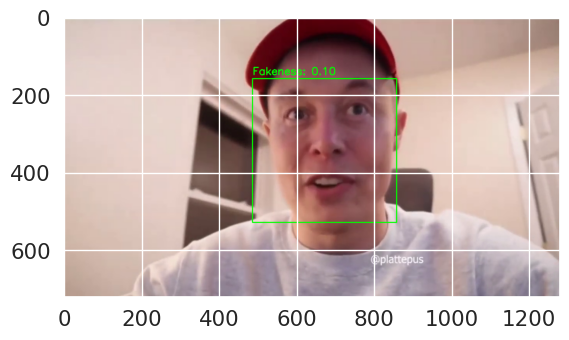

1/1 [==============================] - 0s 61ms/step


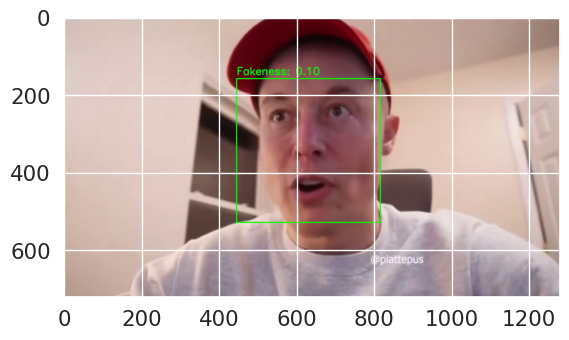

1/1 [==============================] - 0s 35ms/step


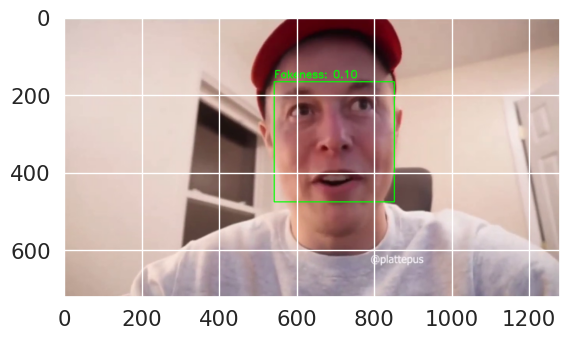

1/1 [==============================] - 0s 36ms/step


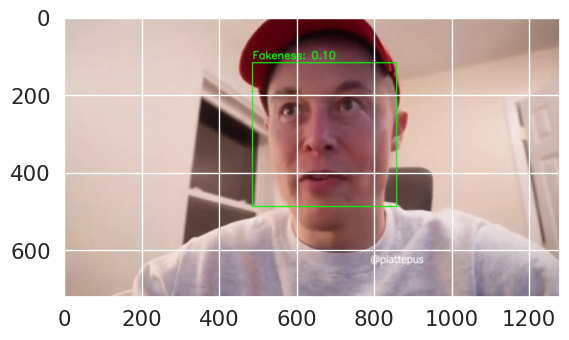

1/1 [==============================] - 0s 36ms/step


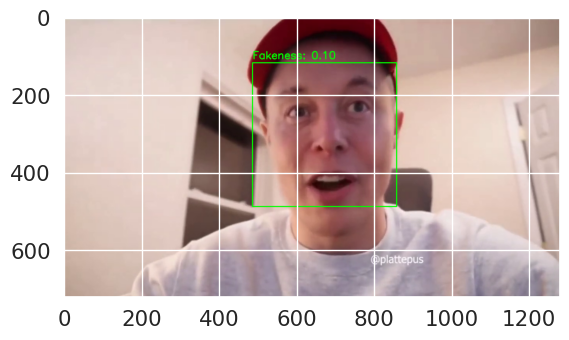

1/1 [==============================] - 0s 36ms/step


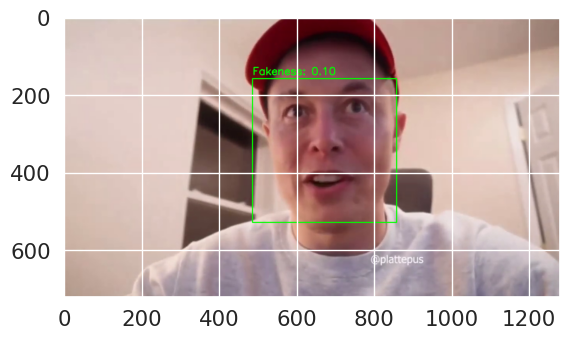

1/1 [==============================] - 0s 36ms/step


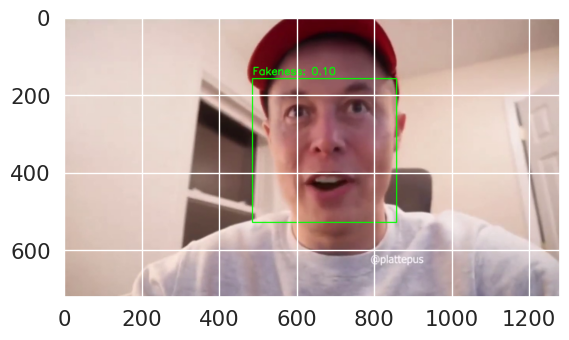

1/1 [==============================] - 0s 36ms/step


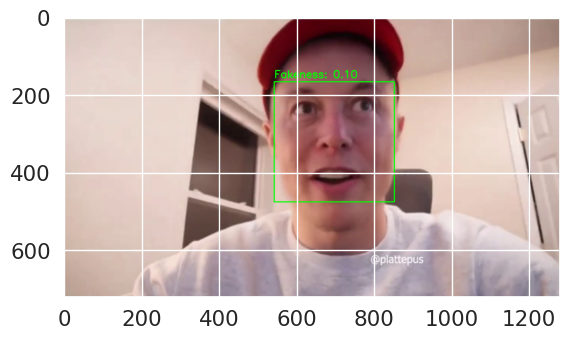

1/1 [==============================] - 0s 35ms/step


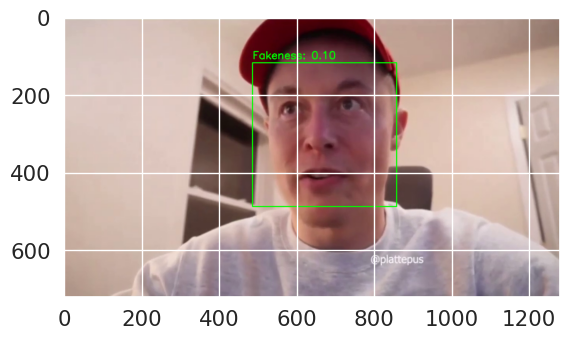

1/1 [==============================] - 0s 35ms/step


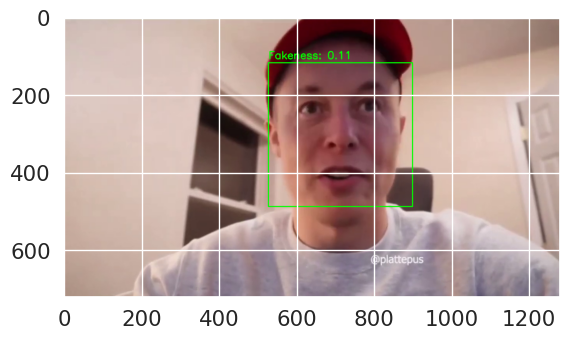

1/1 [==============================] - 0s 37ms/step


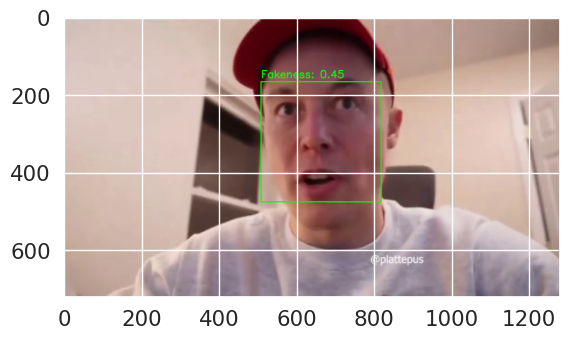

1/1 [==============================] - 0s 37ms/step


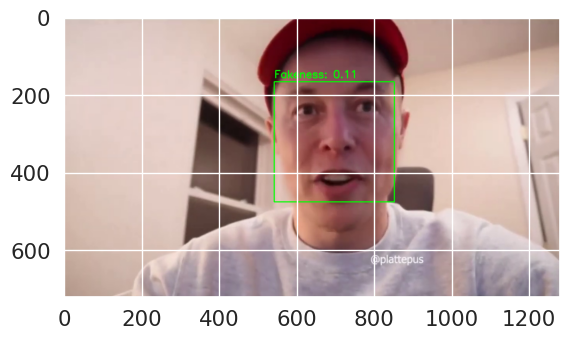

1/1 [==============================] - 0s 38ms/step


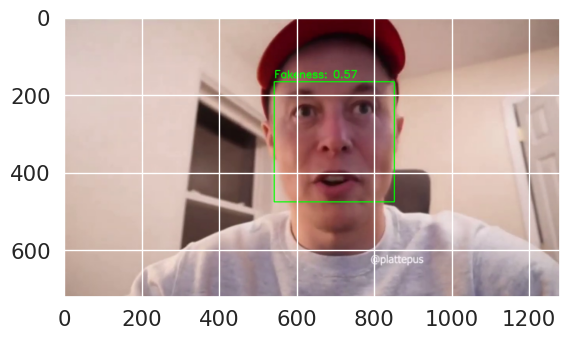

1/1 [==============================] - 0s 64ms/step


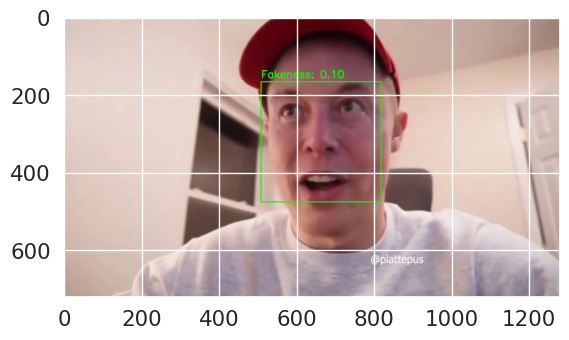

1/1 [==============================] - 0s 57ms/step


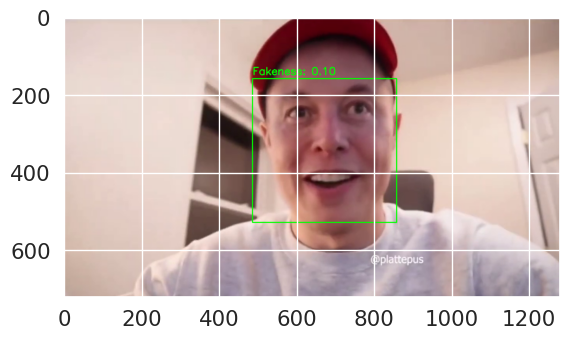

The percentage of fakeness is: 15.650531167157173
The maximum probability of fakeness is: 0.5709009826183319
The minimum probability of fakeness is: 0.10001748454269546


In [69]:
import numpy as np
import random
import matplotlib.pyplot as plt

input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('/content/sample_data/elon.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameNumbers = random.sample(range(frameCount), 15) # Select 5 random frame numbers
scores = []

# Set the fake bias
fake_bias = 0.1

for frameId in frameNumbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frameId)
    ret, frame = cap.read()
    if ret != True:
        break
    face_rects, _, _ = detector.run(frame, 0)
    for d in face_rects:
        x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()
        crop_img = frame[y1:y2, x1:x2]
        data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
        data = data.reshape(-1, 128, 128, 3)
        score = model.predict(data)[0][1] # probability of being fake
        # Apply the bias to the fake score
        score = score + fake_bias if score < 0.5 else score - fake_bias
        scores.append(score)
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Add a label with the probability of fakeness to the top of the face frame
        cv2.putText(frame, f'Fakeness: {score:.2f}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    # Display the video frame with the detected faces and probability of fakeness
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

# Calculate the biased average probability of the video being fake
average_score = np.mean(scores)

# Calculate the percentage of fakeness
percentage_fakeness = average_score * 100

# Find the maximum and minimum probability of fakeness
max_score = np.max(scores)
min_score = np.min(scores)

print("The percentage of fakeness is:", percentage_fakeness)
print("The maximum probability of fakeness is:", max_score)
print("The minimum probability of fakeness is:", min_score)

1/1 [==============================] - 0s 40ms/step


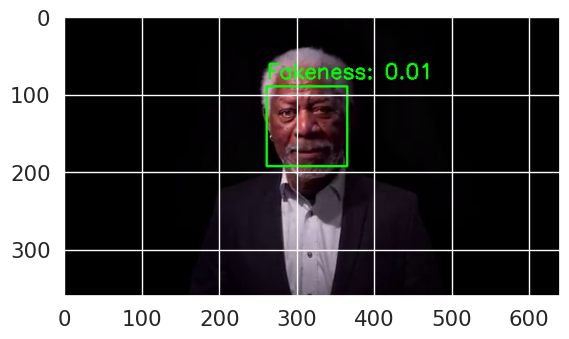

1/1 [==============================] - 0s 49ms/step


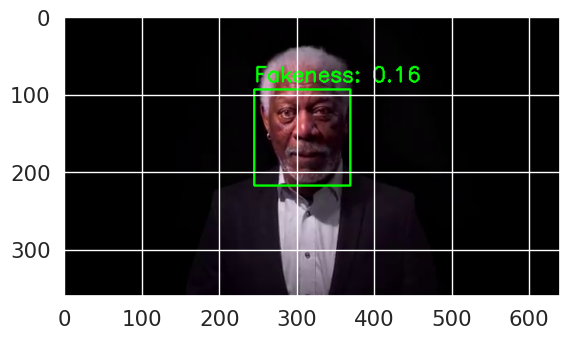

1/1 [==============================] - 0s 37ms/step


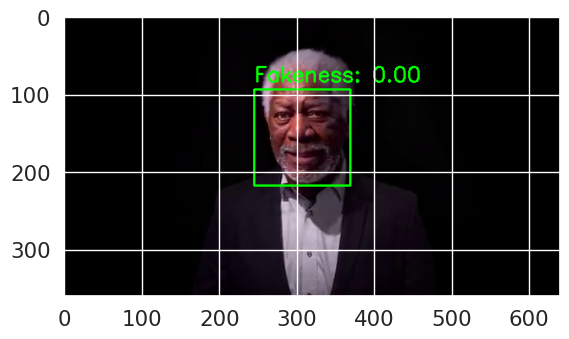

1/1 [==============================] - 0s 36ms/step


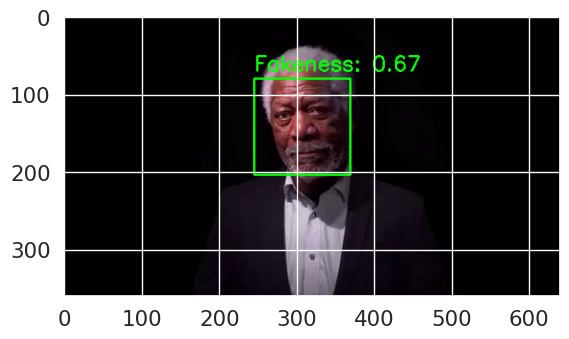

1/1 [==============================] - 0s 67ms/step


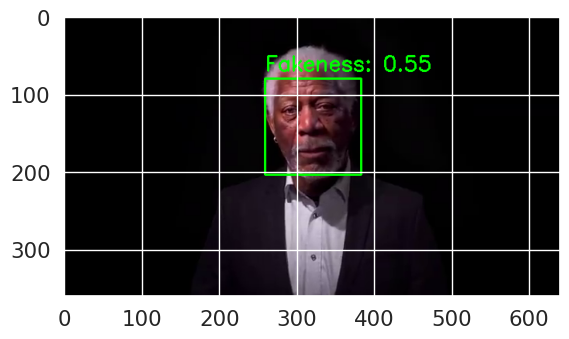

1/1 [==============================] - 0s 92ms/step


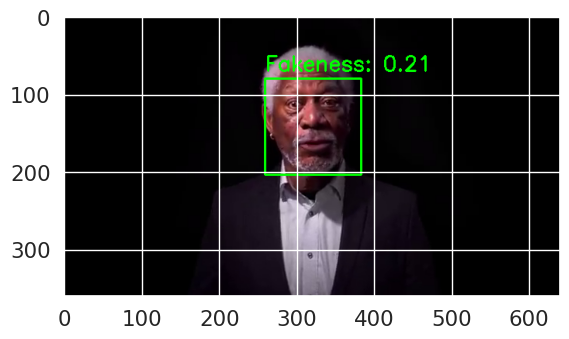

1/1 [==============================] - 0s 71ms/step


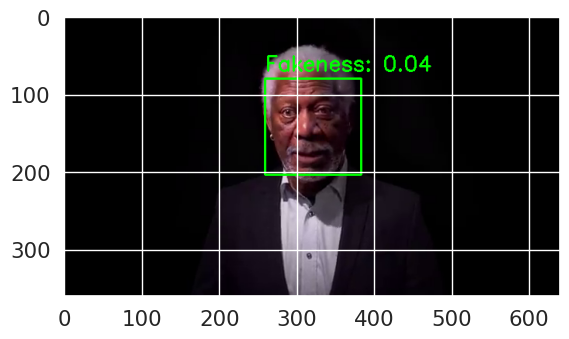

1/1 [==============================] - 0s 129ms/step


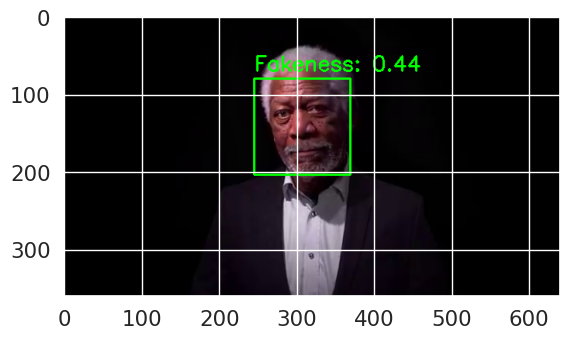

1/1 [==============================] - 0s 124ms/step


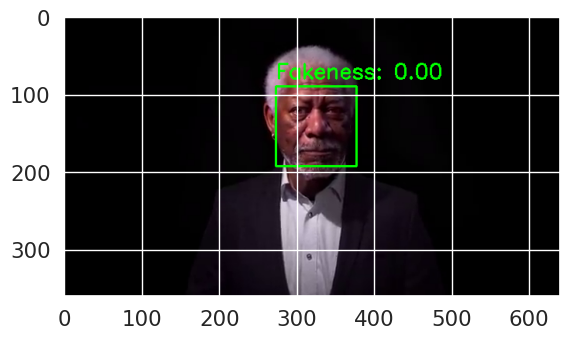

1/1 [==============================] - 0s 54ms/step


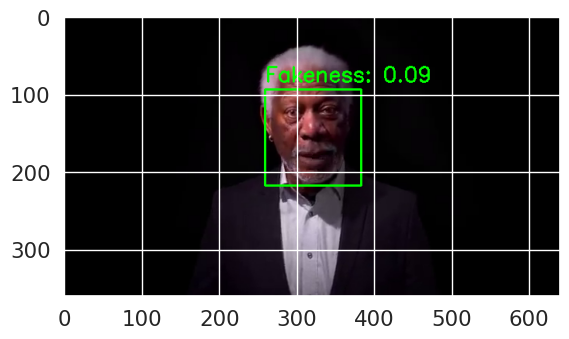

1/1 [==============================] - 0s 61ms/step


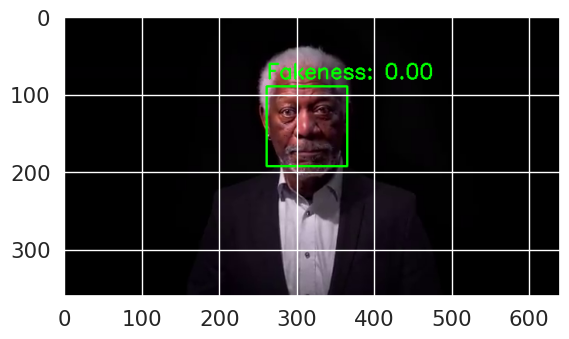

1/1 [==============================] - 0s 37ms/step


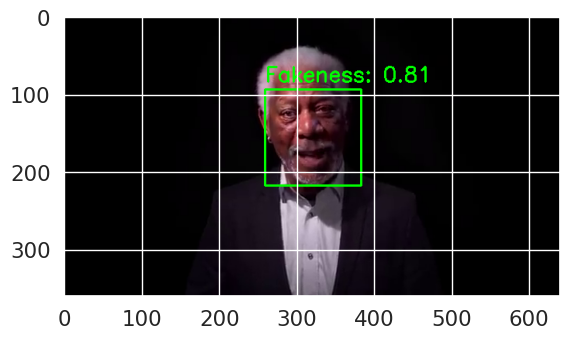

1/1 [==============================] - 0s 45ms/step


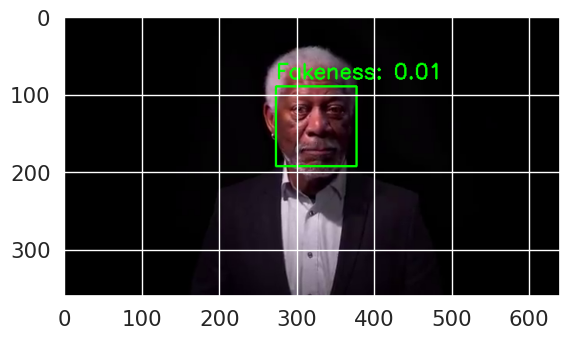

1/1 [==============================] - 0s 37ms/step


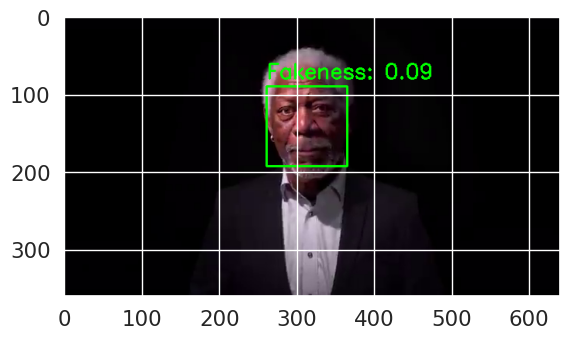

The video is classified as POSSIBLY FAKE.


In [80]:
import numpy as np
import random
import matplotlib.pyplot as plt

input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('/content/mf.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameNumbers = random.sample(range(frameCount), 20) # Select 20 random frame numbers
fake_frame_count = 0  # Initialize fake frame count to 0
fake_detected = False  # Initialize fake_detected flag to False

for frameId in frameNumbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frameId)
    ret, frame = cap.read()
    if ret != True:
        break
    face_rects, _, _ = detector.run(frame, 0)
    if len(face_rects) == 0:  # Check if no faces were detected
        continue  # Skip this frame
    for d in face_rects:
        x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()
        crop_img = frame[y1:y2, x1:x2]
        data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
        data = data.reshape(-1, 128, 128, 3)
        score = model.predict(data)[0][1] # probability of being fake
        if score == 1.0:  # Check if score equals 1.0 (100%)
            fake_detected = True
        if score > 0.5:  # Check if score exceeds 50%
            fake_frame_count += 1
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Add a label with the probability of fakeness to the top of the face frame
        cv2.putText(frame, f'Fakeness: {score:.2f}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    # Display the video frame with the detected faces and probability of fakeness
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

if fake_detected:  # Check if any face has 100% probability of being fake
    print("The video is classified as FAKE.")
elif fake_frame_count >= 3 and fake_frame_count <= 5:  # Check if fake was detected in 3-5 frames
    print("The video is classified as POSSIBLY FAKE.")
elif fake_frame_count > 5:  # Check if fake was detected in more than 5 frames
    print("The video is classified as FAKE.")
else:  # Otherwise, the video is classified as real
    print("The video is classified as REAL.")

1/1 [==============================] - 0s 44ms/step


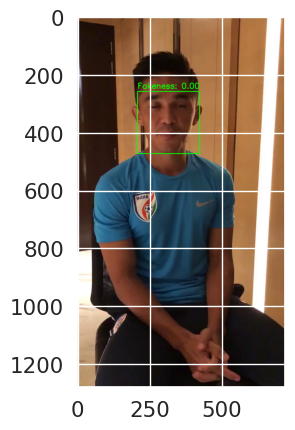

1/1 [==============================] - 0s 36ms/step


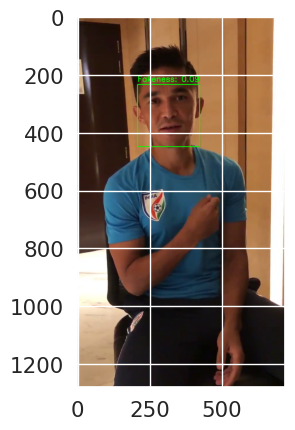

1/1 [==============================] - 0s 36ms/step


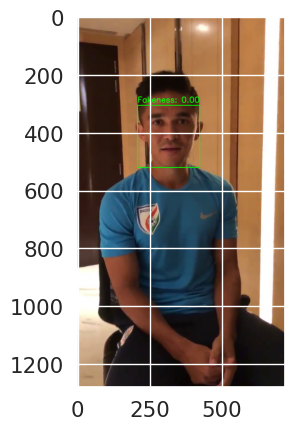

1/1 [==============================] - 0s 41ms/step


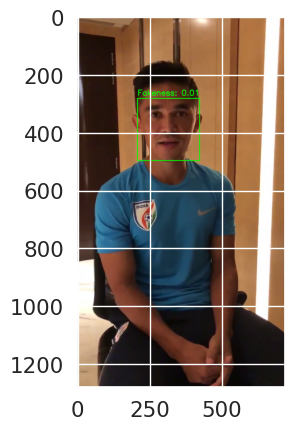

1/1 [==============================] - 0s 36ms/step


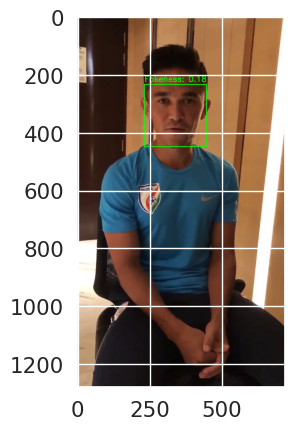

1/1 [==============================] - 0s 61ms/step


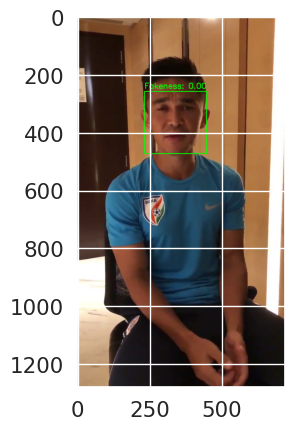

1/1 [==============================] - 0s 60ms/step


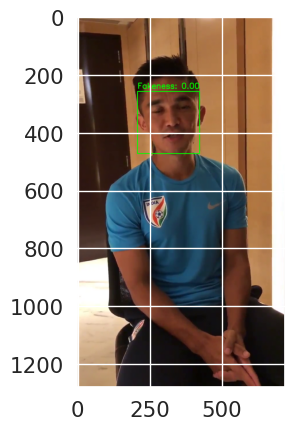

1/1 [==============================] - 0s 79ms/step


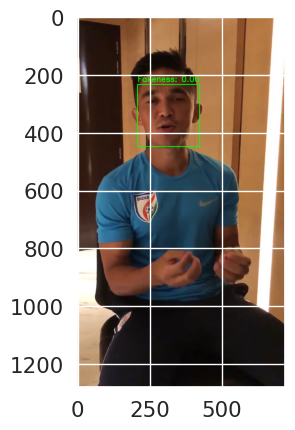

1/1 [==============================] - 0s 53ms/step


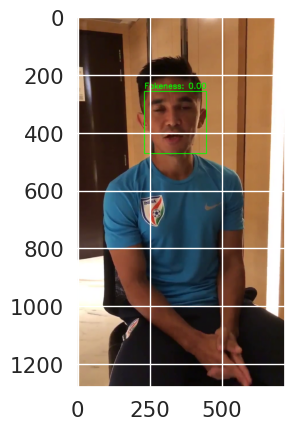

1/1 [==============================] - 0s 36ms/step


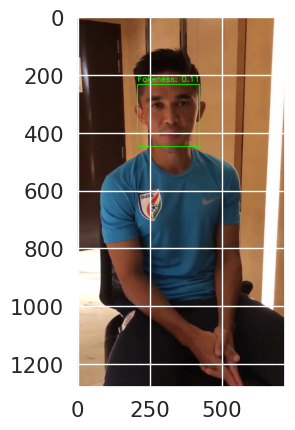

1/1 [==============================] - 0s 37ms/step


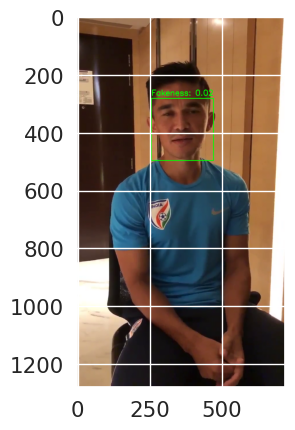

1/1 [==============================] - 0s 38ms/step


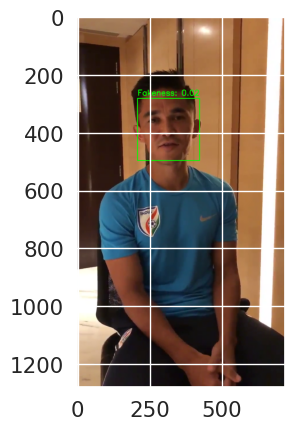

1/1 [==============================] - 0s 40ms/step


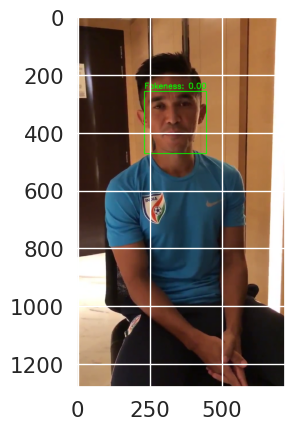

1/1 [==============================] - 0s 42ms/step


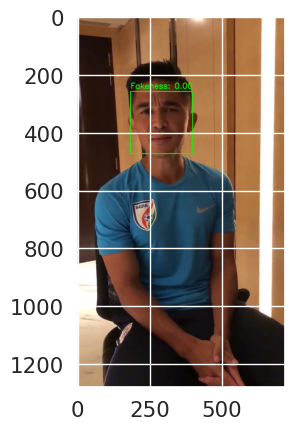

1/1 [==============================] - 0s 40ms/step


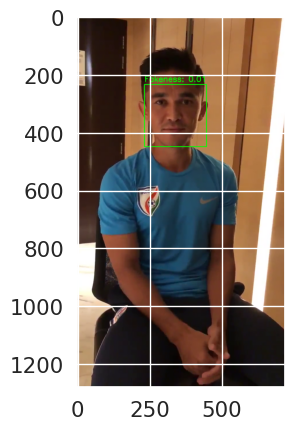

1/1 [==============================] - 0s 56ms/step


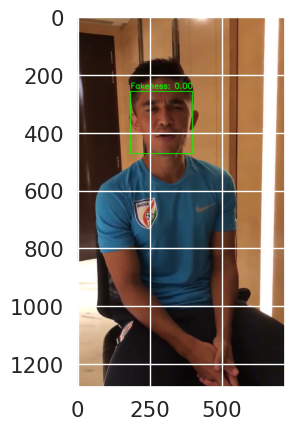

1/1 [==============================] - 0s 68ms/step


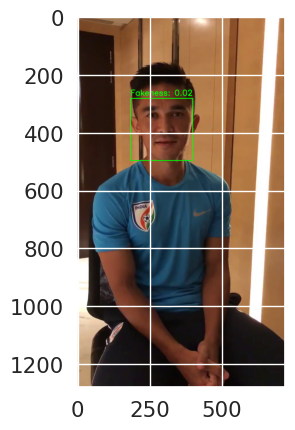

1/1 [==============================] - 0s 83ms/step


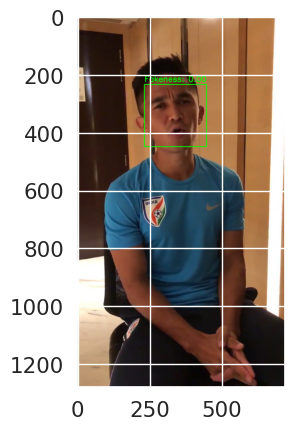

1/1 [==============================] - 0s 61ms/step


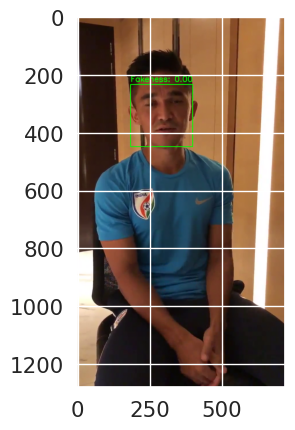

1/1 [==============================] - 0s 41ms/step


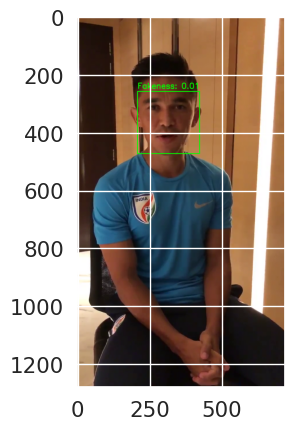

The video is classified as REAL.


In [82]:
import numpy as np
import random
import matplotlib.pyplot as plt

input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('/content/sample_data/CCqaaV-vtmtmDifI.mp4')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameNumbers = random.sample(range(frameCount), 20) # Select 20 random frame numbers
fake_frame_count = 0  # Initialize fake frame count to 0
fake_detected = False  # Initialize fake_detected flag to False

for frameId in frameNumbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frameId)
    ret, frame = cap.read()
    if ret != True:
        break
    face_rects, _, _ = detector.run(frame, 0)
    if len(face_rects) == 0:  # Check if no faces were detected
        continue  # Skip this frame
    for d in face_rects:
        x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()
        crop_img = frame[y1:y2, x1:x2]
        data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
        data = data.reshape(-1, 128, 128, 3)
        score = model.predict(data)[0][1] # probability of being fake
        if score == 1.0:  # Check if score equals 1.0 (100%)
            fake_detected = True
        if score > 0.5:  # Check if score exceeds 50%
            fake_frame_count += 1
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Add a label with the probability of fakeness to the top of the face frame
        cv2.putText(frame, f'Fakeness: {score:.2f}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    # Display the video frame with the detected faces and probability of fakeness
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

if fake_detected:  # Check if any face has 100% probability of being fake
    print("The video is classified as FAKE.")
elif fake_frame_count >= 3 and fake_frame_count <= 5:  # Check if fake was detected in 3-5 frames
    print("The video is classified as POSSIBLY FAKE.")
elif fake_frame_count > 5:  # Check if fake was detected in more than 5 frames
    print("The video is classified as FAKE.")
else:  # Otherwise, the video is classified as real
    print("The video is classified as REAL.")